# Modelo para dectetar neumonia en radiografías

## Librerias

In [12]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,Dropout, BatchNormalization)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


## Procesamiento y carga de datos

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150  # Puedes ajustar este tamaño según tus necesidades

# Rutas de los directorios de datos
train_dir = 'DL/chest_xray/train'
val_dir = 'DL/chest_xray/val'
test_dir = 'DL/chest_xray/test'


In [3]:
def load_data(data_dir):
    images = []
    labels_list = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels_list.append(class_num)
            except Exception as e:
                print(f"Error al cargar la imagen {img_name}: {e}")
        print(f"Cargadas {len(images)} imágenes de la clase '{label}'")
    return np.array(images), np.array(labels_list)

# Cargar los datos de entrenamiento
print("Cargando datos de entrenamiento...")
X_train, y_train = load_data(train_dir)

# Cargar los datos de validación
print("Cargando datos de validación...")
X_val, y_val = load_data(val_dir)

# Cargar los datos de prueba
print("Cargando datos de prueba...")
X_test, y_test = load_data(test_dir)

# Normalizar las imágenes y agregar canal de color
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, img_size, img_size, 1)
X_val = X_val.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)

# Verificar el balance de clases en entrenamiento
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(labels, counts))
print("Distribución de clases en el conjunto de entrenamiento:", class_distribution)

Cargando datos de entrenamiento...
Cargadas 3875 imágenes de la clase 'PNEUMONIA'
Cargadas 5216 imágenes de la clase 'NORMAL'
Cargando datos de validación...
Cargadas 8 imágenes de la clase 'PNEUMONIA'
Cargadas 16 imágenes de la clase 'NORMAL'
Cargando datos de prueba...
Cargadas 390 imágenes de la clase 'PNEUMONIA'
Cargadas 624 imágenes de la clase 'NORMAL'
Distribución de clases en el conjunto de entrenamiento: {'PNEUMONIA': 3875, 'NORMAL': 1341}


## Construir el modelo ajustado

In [4]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights)

# Aumentación de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Generador de datos para validación y prueba (sin aumentación)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Crear generadores de datos
train_generator = train_datagen.flow(
    X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(
    X_val, y_val, batch_size=32, shuffle=False)
test_generator = test_datagen.flow(
    X_test, y_test, batch_size=32, shuffle=False)

Pesos de clase: {0: 0.6730322580645162, 1: 1.9448173005219984}


In [5]:
model = Sequential()

model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con rmsprop
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])



c:\Users\JUANS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:


# Ajustar la aumentación de datos
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Crear generadores de datos
train_generator = train_datagen.flow(
    X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(
    X_val, y_val, batch_size=32, shuffle=False)

# Ajustar los callbacks
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-6)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [7]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/30


c:\Users\JUANS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 477ms/step - accuracy: 0.8026 - loss: 1.3601 - val_accuracy: 0.5000 - val_loss: 27.1017 - learning_rate: 0.0010
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 474ms/step - accuracy: 0.9004 - loss: 0.2605 - val_accuracy: 0.5000 - val_loss: 32.6317 - learning_rate: 0.0010
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 476ms/step - accuracy: 0.9280 - loss: 0.2180 - val_accuracy: 0.5625 - val_loss: 2.8820 - learning_rate: 0.0010
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 476ms/step - accuracy: 0.9357 - loss: 0.1819 - val_accuracy: 0.5625 - val_loss: 9.4606 - learning_rate: 0.0010
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 476ms/step - accuracy: 0.9442 - loss: 0.1594 - val_accuracy: 0.6250 - val_loss: 1.7268 - learning_rate: 0.0010
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 476ms/step - accuracy: 0.9474 - loss: 0.1524 - val_accuracy: 0.7500 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 483ms/step - accuracy: 0.9464 - los

In [13]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9576 - loss: 0.1668
Precisión en el conjunto de prueba: 0.9247


In [14]:
y_pred_prob = model.predict(test_generator)
y_pred_classes = (y_pred_prob > 0.5).astype("int32").flatten()


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


## Matriz de confusión

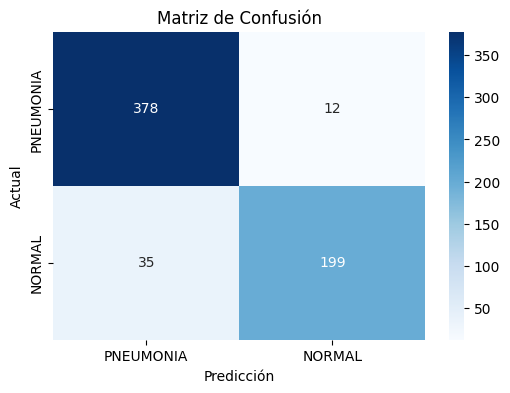

In [16]:
# Obtener las etiquetas reales (corrección del error)
y_true = y_test  # Usamos y_test directamente

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.show()

## 5 radiografías correctamente clasificadas

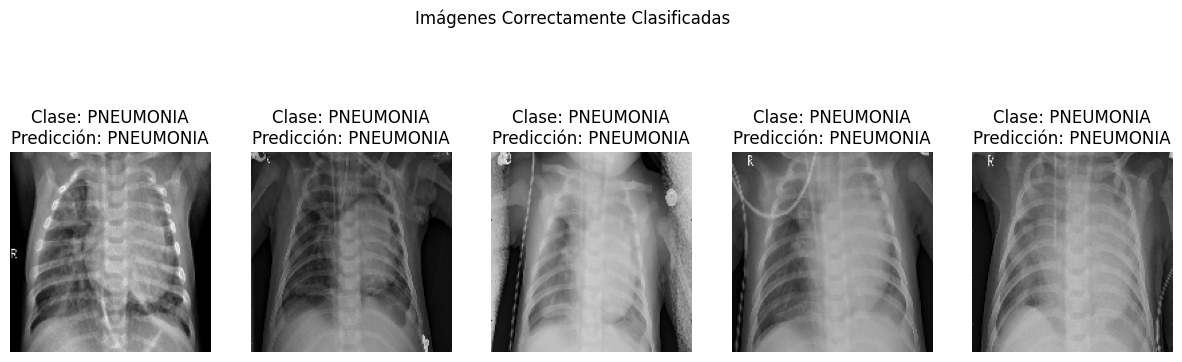

In [17]:
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(15,5))
for i, idx in enumerate(correct_indices[:5]):
    img = X_test[idx].reshape(img_size, img_size)
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Clase: {labels[y_true[idx]]}\nPredicción: {labels[y_pred_classes[idx]]}')
    plt.axis('off')
plt.suptitle('Imágenes Correctamente Clasificadas')
plt.show()

## 5 radiografías mal clasificadas

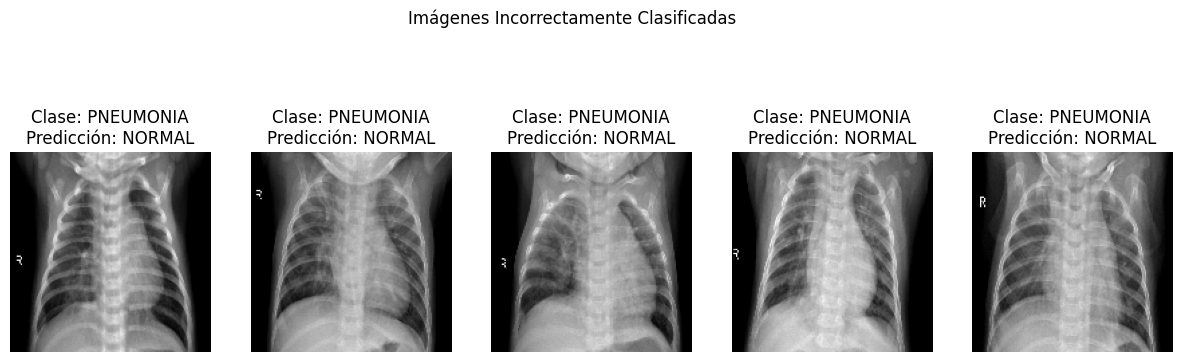

In [18]:
plt.figure(figsize=(15,5))
for i, idx in enumerate(incorrect_indices[:5]):
    img = X_test[idx].reshape(img_size, img_size)
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Clase: {labels[y_true[idx]]}\nPredicción: {labels[y_pred_classes[idx]]}')
    plt.axis('off')
plt.suptitle('Imágenes Incorrectamente Clasificadas')
plt.show()

In [19]:
report = classification_report(y_true, y_pred_classes, target_names=labels, output_dict=True)
print("Informe de clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=labels))


Informe de clasificación:
              precision    recall  f1-score   support

   PNEUMONIA       0.92      0.97      0.94       390
      NORMAL       0.94      0.85      0.89       234

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.92      0.92       624



In [28]:
tp_pneumonia = 0  
fp_pneumonia = 0 

tp_normal = 0     
fp_normal = 0     


for true_label, pred_label in zip(y_true, y_pred_classes):
    if pred_label == labels.index('PNEUMONIA'):
        if pred_label == true_label:
            tp_pneumonia += 1
        else:
            fp_pneumonia += 1
    elif pred_label == labels.index('NORMAL'):
        if pred_label == true_label:
            tp_normal += 1
        else:
            fp_normal += 1


precision_pneumonia = tp_pneumonia / (tp_pneumonia + fp_pneumonia) * 100
precision_normal = tp_normal / (tp_normal + fp_normal) * 100

print(f"Precisión 'PNEUMONIA': {precision_pneumonia:.2f}%")
print(f"Precisión 'NORMAL': {precision_normal:.2f}%")

Precisión 'PNEUMONIA': 91.53%
Precisión 'NORMAL': 94.31%


## Diagrama de torta de precisión de 'PNEUMONIA' y 'NORMAL'

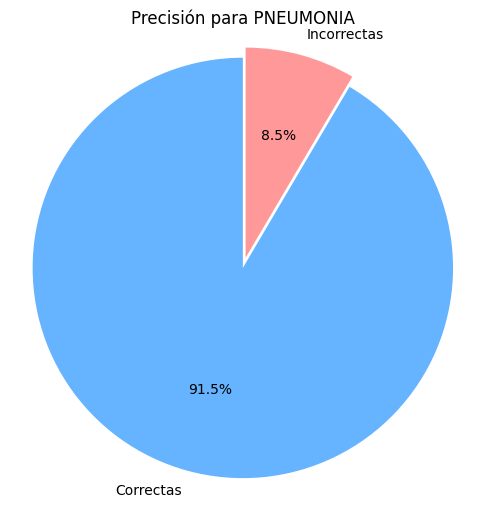

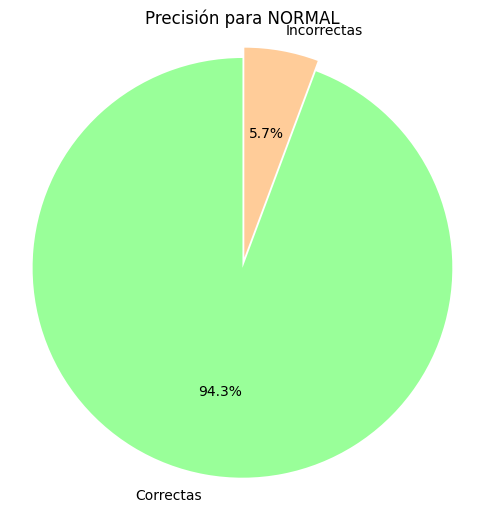

In [31]:
plt.figure(figsize=(6,6))
sizes_pneumonia = [tp_pneumonia, fp_pneumonia]
labels_pneumonia = ['Correctas', 'Incorrectas']
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)  # Destacar la sección de predicciones correctas

plt.pie(sizes_pneumonia, labels=labels_pneumonia, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
plt.title('Precisión para PNEUMONIA')
plt.axis('equal')  # Asegurar que el gráfico sea circular
plt.show()

plt.figure(figsize=(6,6))
sizes_normal = [tp_normal, fp_normal]
labels_normal = ['Correctas', 'Incorrectas']
colors = ['#99ff99', '#ffcc99']
explode = (0.05, 0)

plt.pie(sizes_normal, labels=labels_normal, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
plt.title('Precisión para NORMAL')
plt.axis('equal')
plt.show()

## Curvas de Entrenamiento

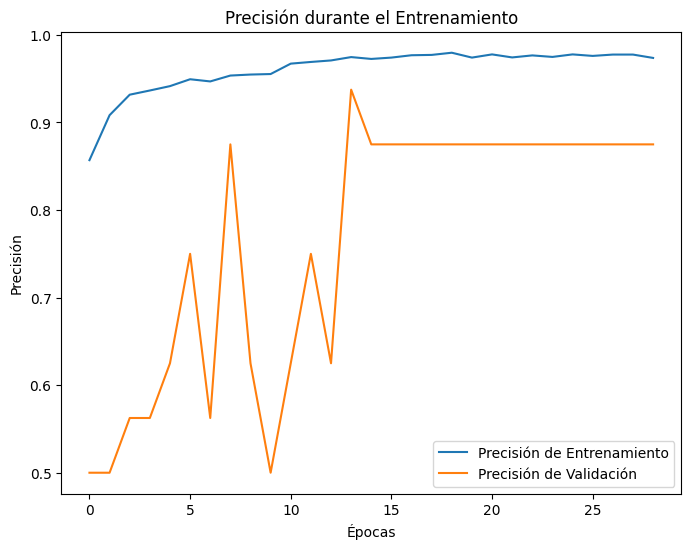

In [21]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

## Curva de  pérdida

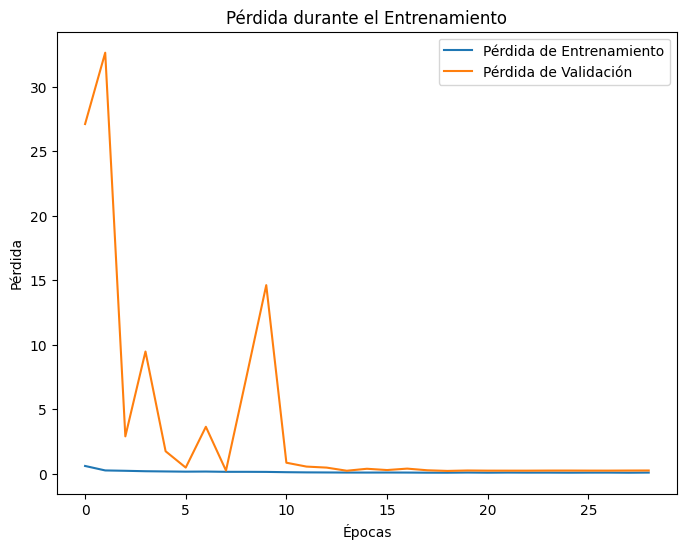

In [22]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


## Curva ROC y AUC

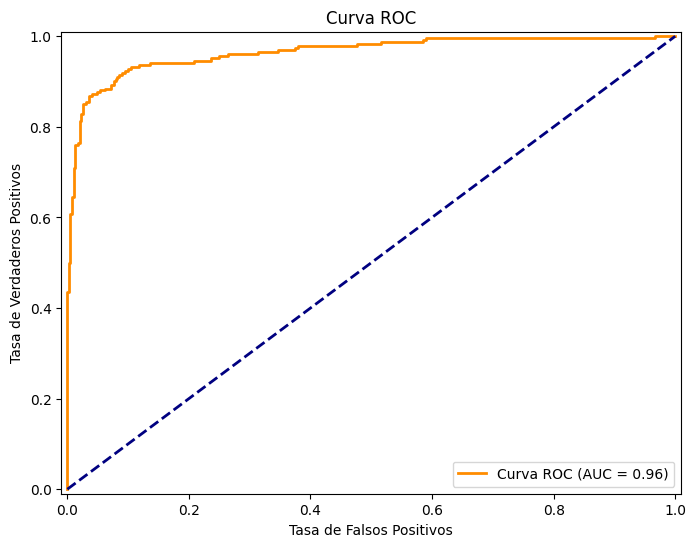

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## Matriz de Confusión Normalizada

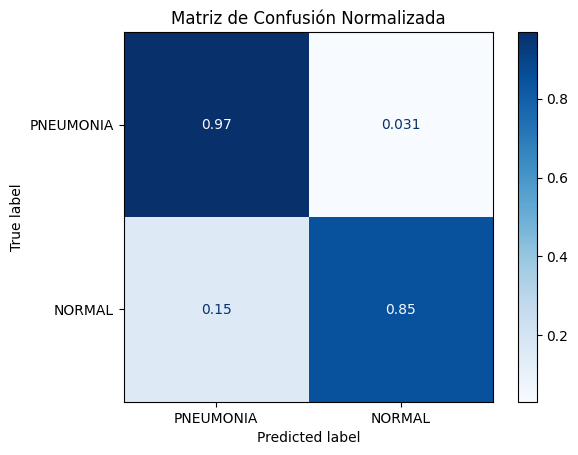

In [24]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred_classes, display_labels=labels, cmap='Blues', normalize='true'
)
disp.ax_.set_title('Matriz de Confusión Normalizada')
plt.show()

# F1-Score por Clase

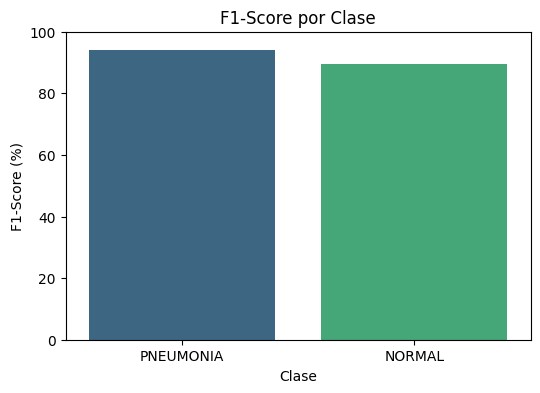

In [25]:
f1_per_class = [report[label]['f1-score']*100 for label in labels]

plt.figure(figsize=(6,4))
sns.barplot(x=labels, y=f1_per_class, palette='viridis')
plt.title('F1-Score por Clase')
plt.ylabel('F1-Score (%)')
plt.xlabel('Clase')
plt.ylim(0, 100)
plt.show()